# Case example of MDAnalysis vs Pysoftk's rgyr_micelle

This Jupyter notebook aims to illustrate how PySoftK provides an enhanced algorithm to compute the radius of gyration (rgyr) of a simulates system that has been broken across the periodic boundary conditions (PBC). Using the MDAnalysis option pbc=True parameters of the implemented rgyr equation. Our appraoch (rgyr_micelle) uses MDAnalysis rgyr function applied to the whole coordinates, so that the PBC are taken into account properly. This leads to a more appropriate calculation of the rgyr of the micelle. 

We are going to perform the rgyr analysis on a micelle that is broken aross the different PBC dimensions. This is the first frame of the trajectory visualized with VMD. There are two polymer aggregates in the simulation. We are only interested in the largest one, so we will first need to get the polymer resid of the micelle we want to run the analysis on.


![Image Alt Text](data/pictures_tutorial/rgyr_initial_all_pol.png)

Thus, we firstly load the trajectory

In [4]:
topology='data/pictures_tutorial/movie_rgyr_cyclic.tpr'
trajectory='data/pictures_tutorial/movie_rgyr_cyclic.xtc'


We need to obtain the resids of the polymers that belong to the largest micelle, since this are the ones that we want to run the analysis on

In [6]:
from  utils_mda import MDA_input
#from pysoftk.pol_analysis.tools.utils_mda import MDA_input
from utils_tools import *
#from pysoftk.pol_analysis.tools.utils_tools import *
from clustering import SCP
#from pysoftk.pol_analysis.clustering import SCP
from make_micelle_whole import micelle_whole
#from pysoftk.pol_analysis.make_micelle_whole import micelle_whole
from rgyr_micelle import rgyr
#from pysoftk.pol_analysis.rgyr_micelle import rgyr

import numpy as np
import pandas as pd

In [7]:
results_name='data/pictures_tutorial/rgyr_comparisson_scp_result'

atom_names= ['O014', 'O00C']

cluster_cutoff = 12

start=0
stop=20001
step=1


#running SCP
c = SCP(topology, trajectory).spatial_clustering_run(start, stop, step, atom_names, cluster_cutoff, results_name)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.08it/s]

The file data/pictures_tutorial/rgyr_comparisson_scp_result.parquet has been successfully created.
Function spatial_clustering_run Took 2.5011 seconds


The results from the clustering are:

In [12]:
#the result from SCP
resids_total = 'data/pictures_tutorial/rgyr_comparisson_scp_result.parquet'

Now, let's obtain the largest micelle resids in every time step selected

In [14]:
largest_micelle_resids = micelle_whole(topology, trajectory).obtain_largest_micelle_resids(resids_total)

print(largest_micelle_resids)

[array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 17, 20]), array([ 1,  2,  3,  4,  7, 10, 11, 12, 14, 15, 16, 17, 20]), array([ 1,  2,  4,  7,  8, 10, 11, 14, 15, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 17, 20]), array([ 1,  2,  3,  4,  8, 10, 11, 12, 14, 15, 16, 17, 20]), array([ 1,  2,  3,  4,  7,  8, 10, 11, 12, 14, 15, 16, 17, 20])]


This is the resid selection for the first frame visualized on VMD, clearly it has selected all polymers in the largest micelle!
![Image Alt Text](data/pictures_tutorial/rgyr_mda_vs_pys_initial.png)

Now that we know the resids, we can start our analysis!

## MDAnalysis rgyr pbc=True 

Before starting any analysis, load the neccesary modules.

In [15]:
import MDAnalysis as mda 
import MDAnalysis.analysis.distances
import numpy as np
import matplotlib.patches as mpatches
import itertools
import MDAnalysis.transformations as trans
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

Load the trajectory on MDAnalysis

In [17]:

u=mda.Universe(topology, trajectory)

Calculate the micelle rgyr for all the analysis frames using the MDAnalysis radius_of_gyration() function

In [29]:

polymer = u.select_atoms('resname S1P1') #resname of the polymers in the simulation


radius_of_gyration_mdanalysis = [] #list where we will store the radius of gyration at each time step


time= []

for ts in tqdm(u.trajectory):
    
   
    
    #creating a list with the resids at each time step so that we can select them at time step, since the number
    #of polymers in the micelle vary over time#####################
    ind = []
    
    
    for item in largest_micelle_resids[int(ts.frame)]:
        
        ind.append(str(item) +' ')
        
        
    ind_f = ' '.join(ind)
    
    ##############################################################
    
    
    
    micelle = polymer.select_atoms('resid ' + str(ind_f)) #selecting the polymers in the micelle at each step
    
    
    radius_of_gyration_mdanalysis.append(micelle.radius_of_gyration(pbc=True)) #rgyr calculation
    
    #creating a time list
    
    time.append(u.trajectory.time/1000000)
    
    
    
    
radius_of_gyration_mdanalysis = np.array(radius_of_gyration_mdanalysis)    

    
time = np.array(time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.70it/s]


Text(0.5, 1.0, '$R_G$ of micelle calculated with MDAanalysis')

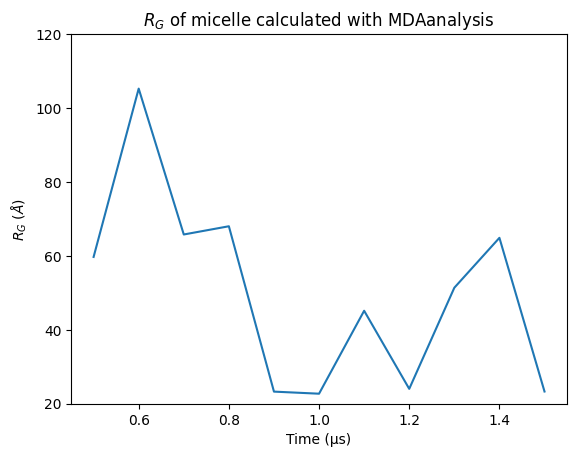

In [35]:

plt.plot(time, radius_of_gyration_mdanalysis)
plt.xlabel('Time (\u03BCs)')
plt.ylabel(r"$R_G$ ($\AA$)")
plt.ylim(20, 120)
plt.title('$R_G$ of micelle calculated with MDAanalysis')


It looks like the rgyr of the micelle calculated with the rgyr MDAnalysis function when this micelle is broken across the PBC outputs values that considerable oscillate, leading us to be skeptic about these results. Let's see what PySoftK rgyr tool reports!

## PySoftK 's rgyr_micelle 

We have already loaded all the modules and calculated the resids of the largest micelle. We only need to obtain the positions of the whole structure to run the rgyr calculation.

In [31]:
#select the resname of the polymers
resname=['S1P1'] 

#run to obtain the whole positions
atom_pos = micelle_whole(topology, trajectory).running_make_cluster_whole(resname, largest_micelle_resids, start, stop, step)

  0%|                                                                                                                                                   | 0/11 [00:00<?, ?it/s]/home/raquellrdc/Desktop/PhD/pysoftk/alejandro_newest_releast_check/pysoftk_analysis_code/test_final/make_micelle_whole.py:347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  atom_positions_over_trajectory = list(tqdm(map(self.make_cluster_whole, frames, resname, cluster_resids_f[0],
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.32s/it]

Elapsed time for matrix calculation: 15.8911 seconds


Now, we have all the neccesary inputs to calculate the radius of gyration of the micelle. Let's run the function!

In [33]:
rgyr_micelle_whole_pysoftk = rgyr(topology, trajectory).running_rgyr(largest_micelle_resids, atom_pos, start, stop, step)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 310.37it/s]


Let's see how the output looks like:

Text(0.5, 1.0, '$R_G$ of micelle calculated with PySoftK')

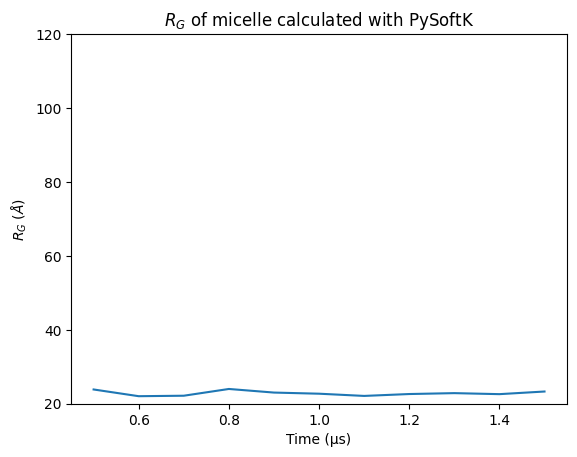

In [36]:

plt.plot(time, rgyr_micelle_whole_pysoftk)
plt.xlabel('Time (\u03BCs)')
plt.ylabel(r"$R_G$ ($\AA$)")
plt.ylim(20, 120)
plt.title('$R_G$ of micelle calculated with PySoftK')


For clarity, this is how the micelle made whole looks in the first step of the trajectory:


![Image Alt Text](data/pictures_tutorial/rgyr_result_arrow.png)

Therefore, it is clear that PySoftK is able to properly take into account the PBC when calculating the radius of gyration expanding the current MDAnalysis' implementation.